In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import GridWorld_v6
import draw

import utils

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super(PolicyNet, self).__init__()
        self.model = nn.Sequential()
        
        self.model.add_module('layer0', nn.Linear(state_dim, hidden_layers[0]))
        cnt = len(hidden_layers)
        for i in range(1, cnt):
            self.model.add_module(f'relu{i}', nn.ReLU())
            self.model.add_module(f'layer{i}', nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.model.add_module(f'relu{cnt}', nn.ReLU())
        self.model.add_module(f'layer{cnt}', nn.Linear(hidden_layers[cnt-1], action_dim))
            
    def forward(self, x):
        output = F.softmax(self.model(x))
        return output
        
    def get_final_layer_parameters(self, x):
        output = self.model(x)
        return output

In [4]:
class REINFORCE:
    def __init__(self, state_dim, hidden_layers, action_dim, env_row, env_column, learning_rate, gamma, device):
        self.action_dim = action_dim
        self.state_dim =state_dim

        self.env_row = env_row
        self.env_column = env_column
        
        # self.weight_tabular = np.full((env_row * env_column, action_dim), 1/action_dim)  #权重矩阵，输出得套softmax层
        self.policy_net = PolicyNet(state_dim, hidden_layers, action_dim).to(device)
        self.device = device
        
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.epsilon = 1

    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        self.policy_net.load_state_dict(torch.load(path, map_location=self.device))

    
    def take_action(self, state):  # 根据动作概率分布随机采样 #state都是（x，y）的
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            
            input = torch.tensor(self.to_one_hot(state[0] * self.env_column + state[1]), dtype=torch.float).to(self.device)
            output = self.policy_net(input)
            now_frame_probabilities  = output.detach().cpu().numpy()
            # print(now_frame_probabilities  )
            try:
                
                action = np.random.choice(self.action_dim, p=now_frame_probabilities)
            except:
                print(self.getProbabilities())
            return action
            
    def to_one_hot(self,x):
        one_hot = np.zeros(self.env_column * self.env_row)
        one_hot[x] = 1
        return one_hot
        
    def getProbabilities(self):
        # 返回一个维度是state*action的概率矩阵，每一行相加和为1
        # states = [(i, j) for i in range(self.env_row) for j in range(self.env_column) ]
        states = [self.to_one_hot(i) for i in range(self.env_row * self.env_column)]
        input = torch.tensor(states, dtype=torch.float).to(self.device)
        output = self.policy_net(input).detach().cpu().numpy()
        return output
    
    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        return_list = [[[]for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)]
        tmp = None

        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起

            reward = reward_list[i]
            state = state_list[i]
            x,y = state[0],state[1]
            action = action_list[i]
            
            G = self.gamma * G + reward
            return_list[x*self.env_column + y][action].append(G)
            
            input = torch.tensor(self.to_one_hot(x * self.env_column + y), dtype=torch.float).to(self.device)
            log_prob = torch.log(self.policy_net(input)[action]) #对概率求log，这个是用来求梯度用的中间变量
            loss = log_prob * G  #乘以G，G是当前这个时刻点到终止时的得分，如果是正的就鼓励它，如果是负的就惩罚它

            loss = -loss  #梯度上升，得把符号逆置一下
            
            loss.backward()
            
            
        #求个平均，免得一次更新那么多，梯度爆炸
        return_mean = np.array([[sum(return_list[i][j]) / len(return_list[i][j] ) if len(return_list[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        return_sum = np.array([[sum(return_list[i][j]) if len(return_list[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        self.return_score = return_sum

        self.optimizer.step()
        

In [5]:
def train(hyperparameters, img_path):
    
    forbiddenAreaScore = hyperparameters['forbiddenAreaScore']
    targetAreaScore = hyperparameters['targetAreaScore']
    hitWallScore = hyperparameters['hitWallScore']
    moveScore = hyperparameters['moveScore']
    start_state = hyperparameters['start_state']
    action_space = hyperparameters['action_space']
    learning_rate = hyperparameters['learning_rate']
    num_episodes = hyperparameters['num_episodes']
    hidden_layers = hyperparameters['hidden_layers']
    gamma = hyperparameters['gamma']
    device = hyperparameters['device']
    
    env = GridWorld_v6.GridWorld_v6(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
                                    desc = [".....",".##..","..#..",".#T#.",".#..."], enterForbiddenArea=False) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#..T",
    #                                         ".....#."]) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#...",
    #                                         ".....#T"]) 
    
    agent = REINFORCE(state_dim = env.rows * env.columns, 
              hidden_layers = hidden_layers, 
              action_dim = env.get_action_space(), 
              env_row = env.rows, 
              env_column = env.columns, 
              learning_rate = learning_rate, 
              gamma = gamma,
              device = device)
    if hyperparameters['use_pretrained_model'] == True:
        agent.load_model(hyperparameters['pretrained_model'])
    print(agent.policy_net)
    return_list = []

    epsilon = hyperparameters['begin_epsilon']
    final_epsilon = hyperparameters['final_epsilon']
    for i in tqdm(range(num_episodes)):# 10000
        if(epsilon > final_epsilon) :
            epsilon -= hyperparameters['gamma_minus_each_episodes']
        else:
            epsilon = final_epsilon
        agent.epsilon = epsilon

        episode_return = 0
        transition_dict = {
            'states': [],
            'actions': [],
            'next_states': [],
            'rewards': [],
            'dones': []
        }
        state = env.reset()
        done = False
        cnt = 0
        while not done:
            cnt = cnt + 1
            action = agent.take_action(state) ########
            next_state, reward, done, _ = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
            if cnt>hyperparameters['exploring_step']:
                break
            
        return_list.append(episode_return)
        pre_frame_probabilities = agent.getProbabilities()
        agent.update(transition_dict)
        now_frame_probabilities = agent.getProbabilities()
        
        if i % 1000 == 0:
            # print(pre_frame_probabilities)
            # print(now_frame_probabilities)
            # print(agent.return_score)
            draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.return_score , transition_dict['states'], env.get_map_description(), img_path+f"epi-{i}")
            agent.save_model('./models/'+f"{i}.pth")
    draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.return_score , transition_dict['states'], env.get_map_description(), img_path)

experiments/Penalty0_Score3_State(0~24)/Penalty0_Score3_State0
PolicyNet(
  (model): Sequential(
    (layer0): Linear(in_features=25, out_features=16, bias=True)
    (relu1): ReLU()
    (layer1): Linear(in_features=16, out_features=32, bias=True)
    (relu2): ReLU()
    (layer2): Linear(in_features=32, out_features=4, bias=True)
  )
)


  0%|                                                                                                  | 0/200000 [00:00<?, ?it/s]/tmp/ipykernel_29796/4234279757.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.model(x))


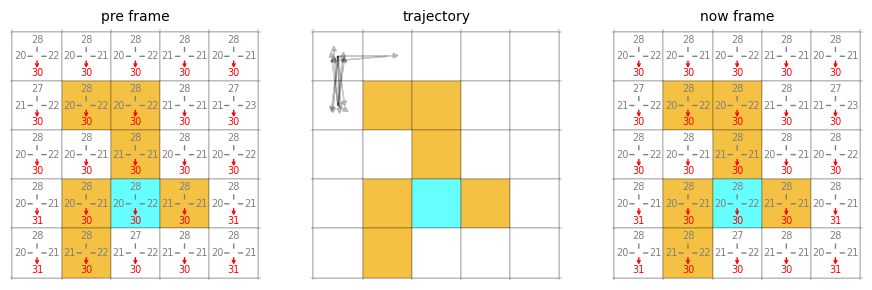

  0%|▍                                                                                     | 996/200000 [00:24<1:13:45, 44.97it/s]

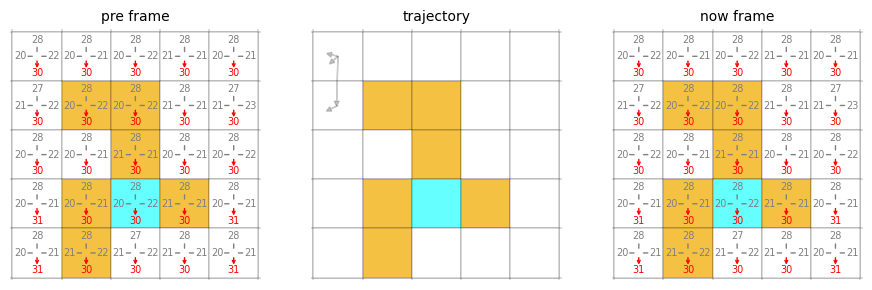

  1%|▊                                                                                    | 1998/200000 [00:49<1:18:45, 41.90it/s]

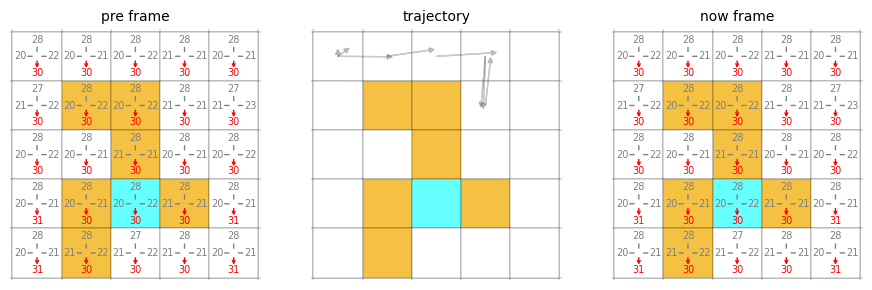

  1%|█▎                                                                                   | 2997/200000 [01:14<1:10:40, 46.46it/s]

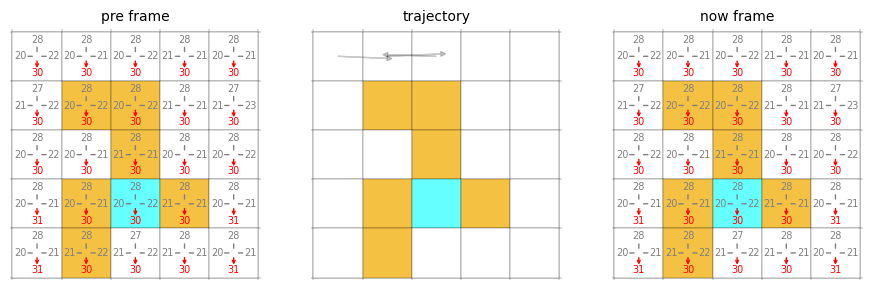

  2%|█▋                                                                                   | 3996/200000 [01:40<1:01:47, 52.86it/s]

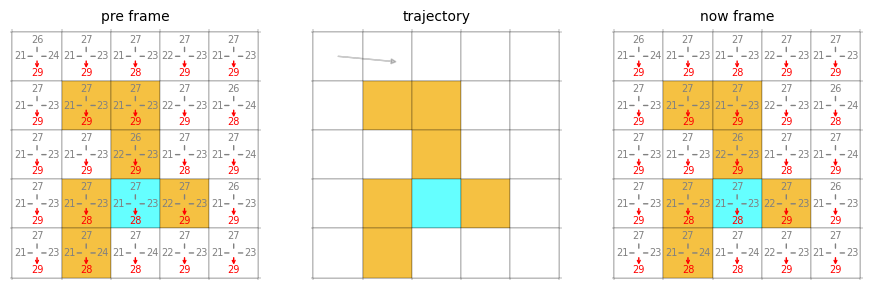

  2%|██                                                                                   | 4997/200000 [02:04<1:09:12, 46.96it/s]

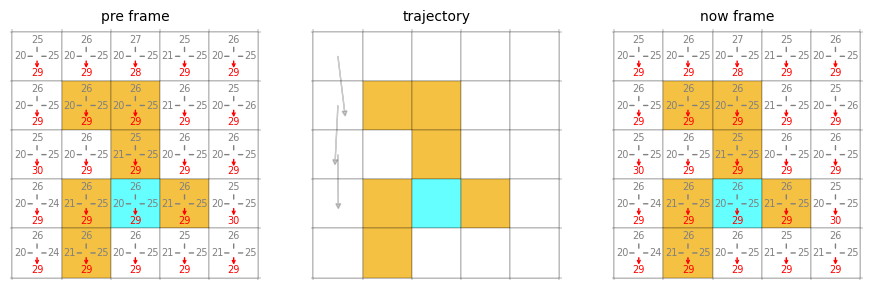

  3%|██▌                                                                                  | 5998/200000 [02:27<1:05:52, 49.09it/s]

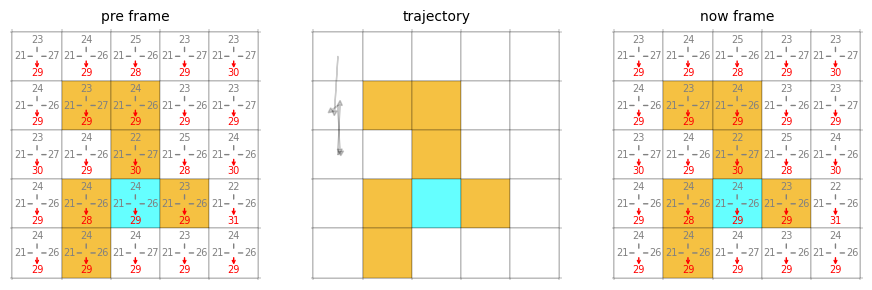

  3%|██▉                                                                                  | 6997/200000 [02:49<1:05:38, 49.00it/s]

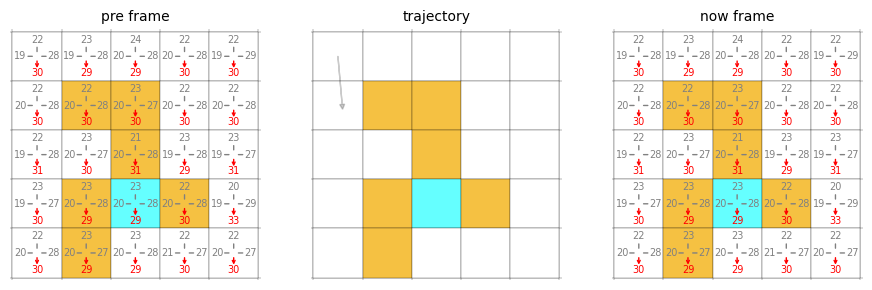

  4%|███▍                                                                                 | 7998/200000 [03:12<1:04:52, 49.33it/s]

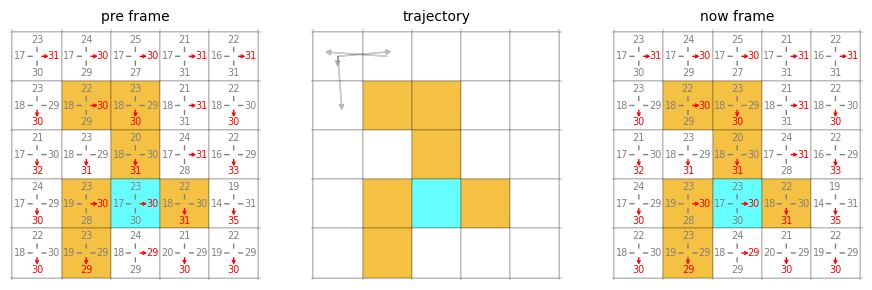

  4%|███▉                                                                                   | 8997/200000 [03:36<57:31, 55.34it/s]

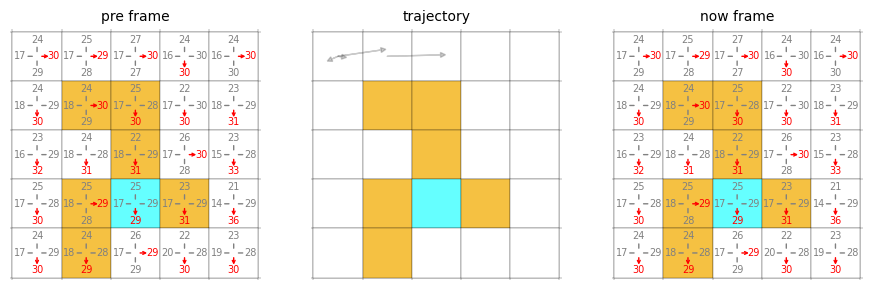

  5%|████▎                                                                                 | 10000/200000 [04:01<57:55, 54.67it/s]

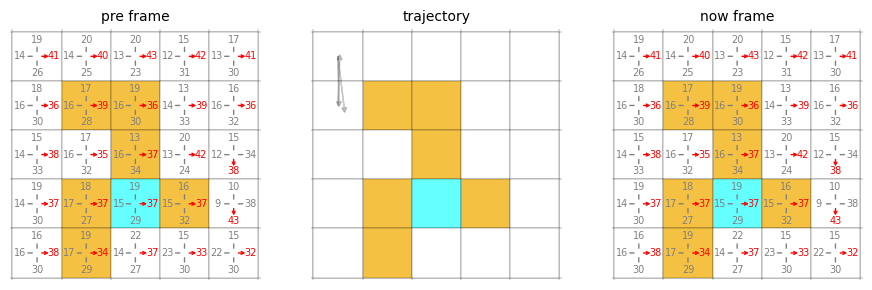

  5%|████▌                                                                               | 10999/200000 [04:40<2:19:29, 22.58it/s]

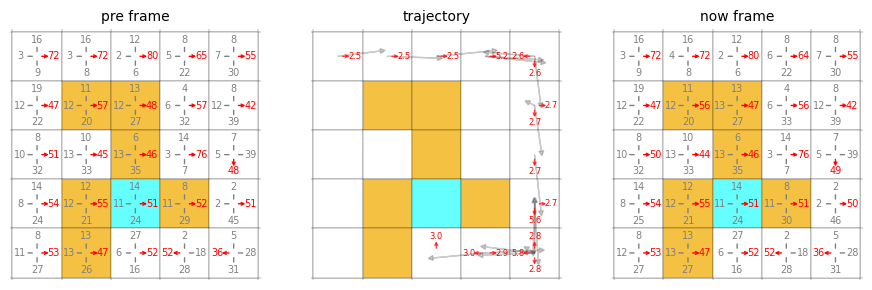

  6%|█████                                                                               | 12000/200000 [05:37<2:03:31, 25.36it/s]

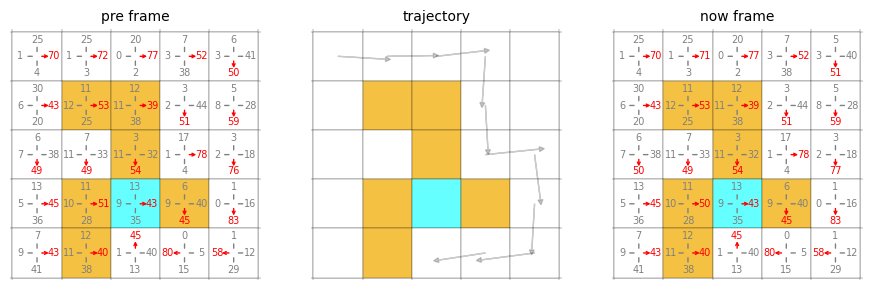

  6%|█████▍                                                                              | 12999/200000 [06:28<2:16:21, 22.86it/s]

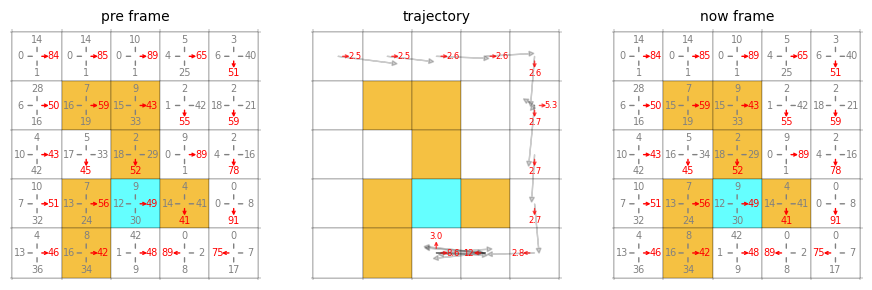

  7%|█████▉                                                                              | 13999/200000 [07:12<2:11:06, 23.64it/s]

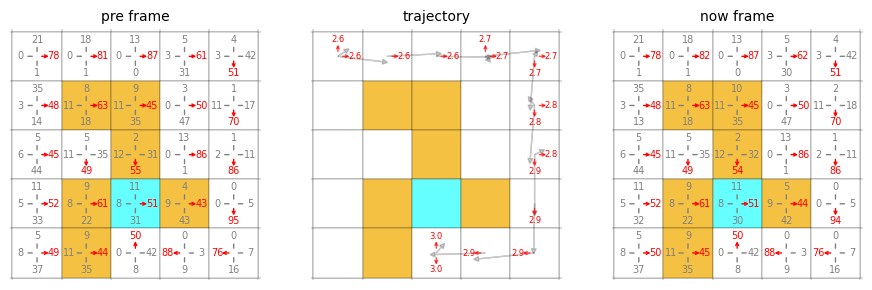

  8%|██████▎                                                                             | 15000/200000 [07:59<2:08:50, 23.93it/s]

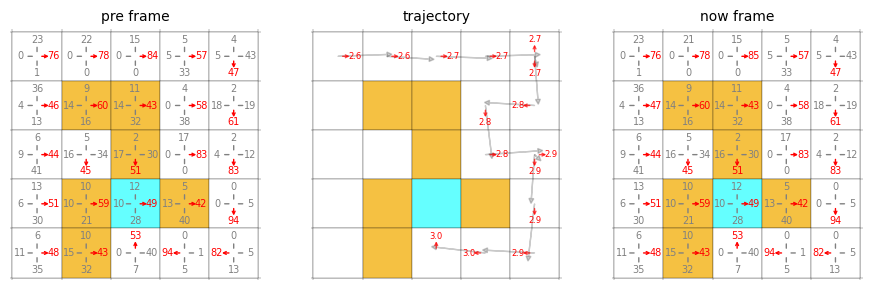

  8%|██████▋                                                                             | 15998/200000 [08:44<2:52:40, 17.76it/s]

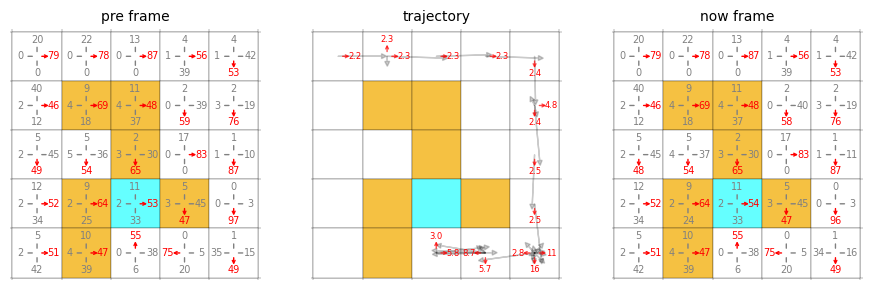

  8%|███████▏                                                                            | 16998/200000 [09:33<2:20:35, 21.69it/s]

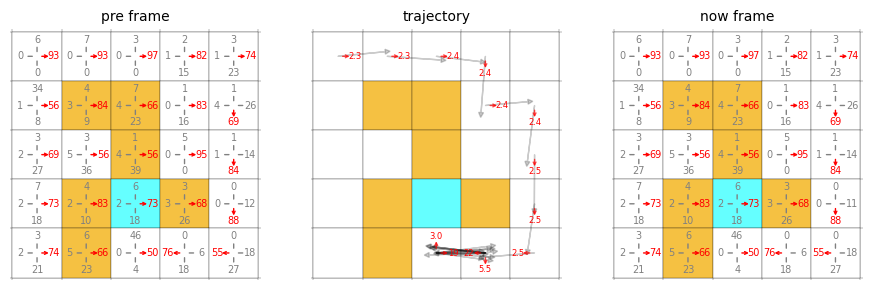

  9%|███████▌                                                                            | 18000/200000 [10:17<2:10:24, 23.26it/s]

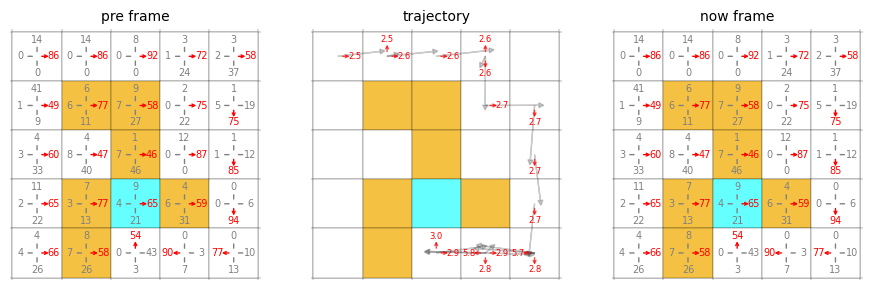

  9%|███████▉                                                                            | 18999/200000 [11:00<2:08:42, 23.44it/s]

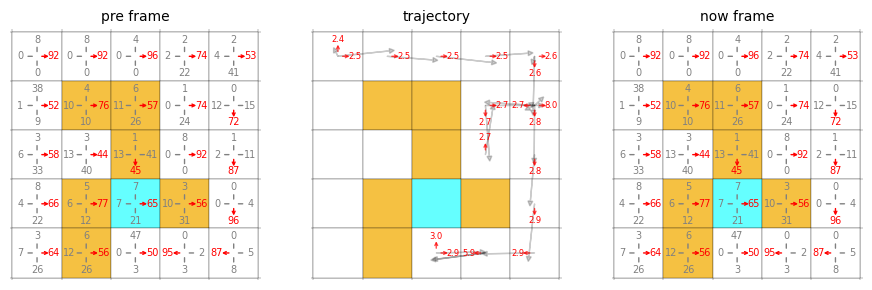

 10%|████████▍                                                                           | 19998/200000 [11:41<2:00:58, 24.80it/s]

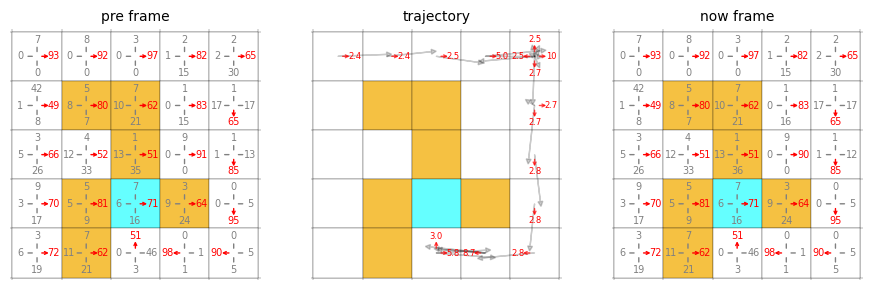

 10%|████████▊                                                                           | 21000/200000 [12:30<2:08:21, 23.24it/s]

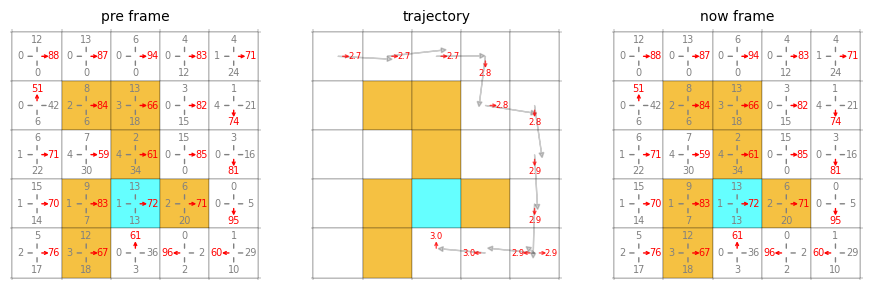

 11%|█████████▏                                                                          | 21998/200000 [13:22<2:10:03, 22.81it/s]

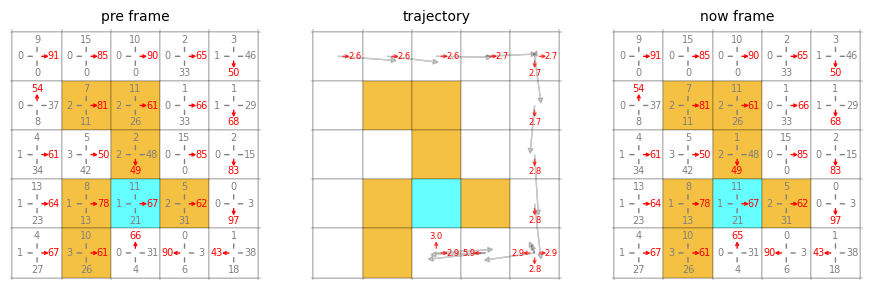

 11%|█████████▋                                                                          | 22999/200000 [14:04<2:01:21, 24.31it/s]

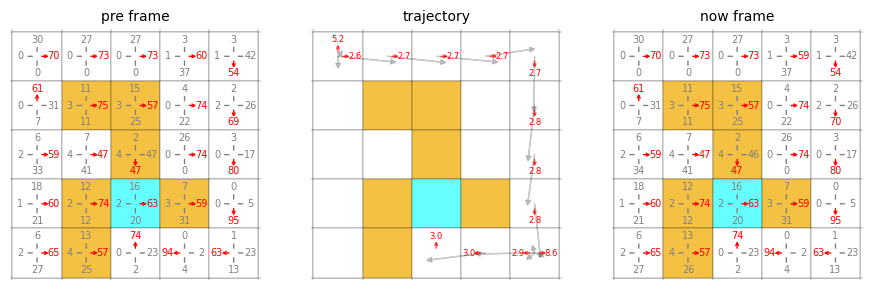

 12%|██████████                                                                          | 23998/200000 [14:46<1:39:32, 29.47it/s]

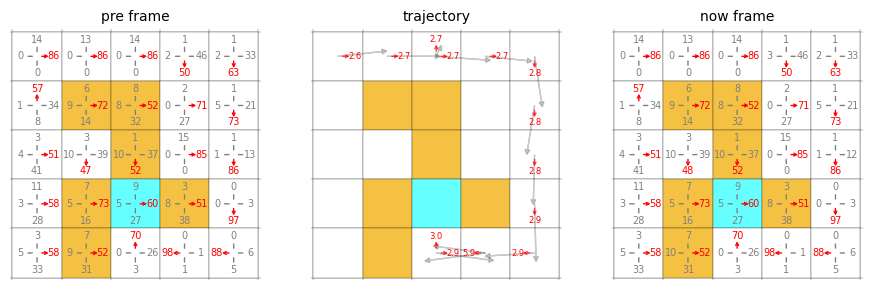

 12%|██████████▍                                                                         | 24999/200000 [15:25<1:27:58, 33.15it/s]

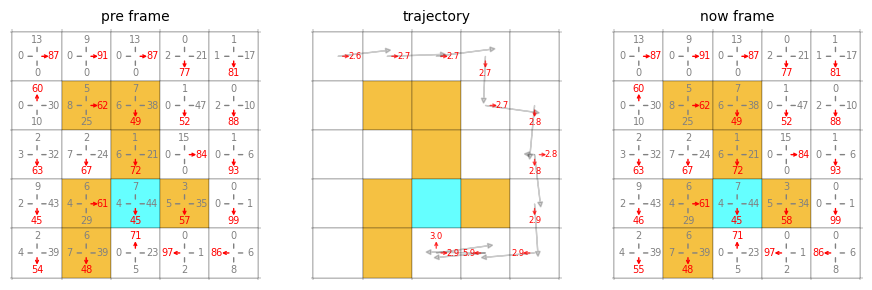

 13%|██████████▉                                                                         | 25999/200000 [16:03<1:34:35, 30.66it/s]

In [ ]:
hyperparameters = {
    'forbiddenAreaScore': 0,  #踩陷阱和碰壁的惩罚
    'hitWallScore': 0,
    'targetAreaScore': 3,     #奖励
    'moveScore': 0,            #移动惩罚
    'action_space': 4,         
    'learning_rate': 0.0005,    
    'hidden_layers': [16,32],
    'gamma': 0.99,              #折扣因子
    'num_episodes': 200000,      #训练轮次，每次训练epsilon -= gamma_minus_each_episodes
    'start_state': 0,
    'exploring_step':50, ##########################
    
    'begin_epsilon':0,
    'final_epsilon':0,
    'gamma_minus_each_episodes':0.00005,

    'device':torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),

    'use_pretrained_model':False,
    'pretrained_model':'./models/24-40000.pth'
}

start_state = hyperparameters['start_state']

# 创建 images 文件夹（如果不存在）
experiment_name = f"Penalty{hyperparameters['forbiddenAreaScore']}_Score{hyperparameters['targetAreaScore']}_State"
output_dir = f"experiments/{experiment_name}(0~24)/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 图片文件路径

img_name = f"{experiment_name}{start_state}"
img_path = os.path.join(output_dir, img_name)
xlsx_path = os.path.join(output_dir, experiment_name+".xlsx")
print(img_path)
train(hyperparameters, img_path)

utils.write_excel(hyperparameters ,img_path+'.png', bias = start_state, xlsx_path=xlsx_path, highlights=['start_state'])


In [ ]:
###############################################################
###############################################################
############TEST###########


    
forbiddenAreaScore = hyperparameters['forbiddenAreaScore']
targetAreaScore = hyperparameters['targetAreaScore']
hitWallScore = hyperparameters['hitWallScore']
moveScore = hyperparameters['moveScore']
start_state = hyperparameters['start_state']
action_space = hyperparameters['action_space']
learning_rate = hyperparameters['learning_rate']
num_episodes = hyperparameters['num_episodes']
hidden_layers = hyperparameters['hidden_layers']
gamma = hyperparameters['gamma']
device = hyperparameters['device']

env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
                                desc = [".....",".##..","..#..",".#T#.",".#..."]) 

# env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
#                                 desc = ["...#..T",
#                                         ".....#."]) 

# env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
#                                 desc = ["...#...",
#                                         ".....#T"]) 

agent = REINFORCE(state_dim = env.get_observation_space(), 
          hidden_layers = hidden_layers, 
          action_dim = env.rows * env.columns, 
          env_row = env.rows, 
          env_column = env.columns, 
          learning_rate = learning_rate, 
          gamma = gamma,
          device = device)
if hyperparameters['use_pretrained_model'] == True:
    agent.load_model(hyperparameters['pretrained_model'])
print(agent.policy_net)



In [ ]:
agent.load_model('./models/test-4000.pth')
fake_action_list = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
# 伪造序列

episode_return = 0
transition_dict = {
    'states': [],
    'actions': [],
    'next_states': [],
    'rewards': [],
    'dones': []
}
state = env.reset()
done = False
cnt = 0



for fake_action in fake_action_list:
    action = fake_action
    next_state, reward, done, _ = env.step(action)
    transition_dict['states'].append(state)
    transition_dict['actions'].append(action)
    transition_dict['next_states'].append(next_state)
    transition_dict['rewards'].append(reward)
    transition_dict['dones'].append(done)
    state = next_state

    

pre_frame_probabilities = agent.getProbabilities()
agent.update(transition_dict)
now_frame_probabilities = agent.getProbabilities()

print(agent.return_score)


states = [(i, j) for i in range(agent.env_row) for j in range(agent.env_column) ]
input = torch.tensor(states, dtype=torch.float).to(agent.device)
output = agent.policy_net(input).detach().cpu().numpy()

print(agent.policy_net.get_final_layer_parameters)

draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.return_score , transition_dict['states'], env.get_map_description(), img_path+f"epi-test")
